In [5]:
# Quick validation test - no TensorFlow yet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add parent directory for imports
sys.path.append('..')
from utils import *
from config import *

print("✅ Basic imports working")
print(f"📁 Dataset path: {PHYSIONET_DIR}")
print(f"📊 Path exists: {PHYSIONET_DIR.exists()}")

# Test dataset loading  
labels_df = get_physionet_labels(str(PHYSIONET_DIR))
print(f"📋 Found {len(labels_df)} labeled files")
if len(labels_df) > 0:
    print(f"📊 Distribution: {labels_df['binary_label'].value_counts().to_dict()}")
    print("🎉 Dataset loading works!")

ModuleNotFoundError: No module named 'librosa'

In [3]:
import tensorflow as tf

In [3]:
# Test audio processing pipeline
import librosa
import soundfile as sf
import warnings
warnings.filterwarnings('ignore')

print("🎵 Testing audio processing...")

# Test one file
sample_file = labels_df.iloc[0]
print(f"🔍 Testing: {sample_file['file_id']} ({sample_file['binary_label']})")

# Load audio
audio, sr = load_audio(sample_file['file_path'], target_sr=SAMPLE_RATE)
print(f"✅ Loaded: {len(audio)} samples at {sr}Hz ({len(audio)/sr:.1f}s)")

# Preprocess
processed = preprocess_audio(audio, sr, duration=AUDIO_DURATION)
print(f"✅ Processed: {len(processed)} samples ({len(processed)/sr:.1f}s)")

# Convert to spectrogram
mel_spec = audio_to_melspectrogram(processed, sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
print(f"✅ Spectrogram: {mel_spec.shape}")

print("🎉 Audio processing pipeline works!")
print(f"📊 Ready to process {len(labels_df)} files total")

🎵 Testing audio processing...
🔍 Testing: a0001 (abnormal)
✅ Loaded: 285328 samples at 8000Hz (35.7s)
✅ Processed: 40000 samples (5.0s)
✅ Spectrogram: (128, 157)
🎉 Audio processing pipeline works!
📊 Ready to process 3240 files total


In [4]:
# Mini-training test with 100 processed files
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

print("🚀 Starting mini-training test with 100 files...")

# Load the preprocessing results
results_path = DATA_DIR / "preprocessing_results.csv"
if results_path.exists():
    processed_df = pd.read_csv(results_path)
    print(f"📊 Loaded {len(processed_df)} processed files")
    print(f"   Classes: {processed_df['label'].value_counts().to_dict()}")
else:
    print("❌ No preprocessing results found. Run the preprocessing script first.")
    
# Create simple train/val split for mini test
if len(processed_df) > 0:
    train_df, val_df = train_test_split(
        processed_df, test_size=0.2, stratify=processed_df['label'], random_state=42
    )
    print(f"📋 Mini-dataset split:")
    print(f"   Train: {len(train_df)} files")
    print(f"   Val: {len(val_df)} files")
    
    # Test loading a few spectrograms
    sample_specs = []
    sample_labels = []
    
    for idx, row in train_df.head(10).iterrows():
        try:
            spec = np.load(row['spectrogram_path'])
            sample_specs.append(spec)
            sample_labels.append(1 if row['label'] == 'abnormal' else 0)
        except:
            continue
    
    if len(sample_specs) > 0:
        print(f"✅ Successfully loaded {len(sample_specs)} sample spectrograms")
        print(f"   Spectrogram shape: {sample_specs[0].shape}")
        print(f"   Labels: {np.unique(sample_labels, return_counts=True)}")
        print("🎉 Mini-dataset ready for training!")

🚀 Starting mini-training test with 100 files...
📊 Loaded 100 processed files
   Classes: {'abnormal': 71, 'normal': 29}
📋 Mini-dataset split:
   Train: 80 files
   Val: 20 files
✅ Successfully loaded 10 sample spectrograms
   Spectrogram shape: (128, 157)
   Labels: (array([0, 1]), array([3, 7]))
🎉 Mini-dataset ready for training!


In [5]:
# Test TensorFlow import with fixed protobuf
import warnings
warnings.filterwarnings('ignore')

print("🔧 Testing TensorFlow import...")
try:
    import tensorflow as tf
    print(f"✅ TensorFlow {tf.__version__} imported successfully")
    print(f"🖥️ GPU available: {len(tf.config.list_physical_devices('GPU'))} devices")
    
    # Test basic operations
    test_tensor = tf.constant([1, 2, 3])
    print(f"✅ TensorFlow operations working: {test_tensor}")
    
except Exception as e:
    print(f"❌ TensorFlow import failed: {e}")
    print("💡 Trying fallback to CPU-only mode...")
    
    # Try importing with environment variable
    import os
    os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
    try:
        import tensorflow as tf
        print(f"✅ TensorFlow {tf.__version__} imported with CPU fallback")
    except Exception as e2:
        print(f"❌ Complete TensorFlow failure: {e2}")
        print("🔄 Recommend restarting kernel and trying again")

🔧 Testing TensorFlow import...
❌ TensorFlow import failed: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates
💡 Trying fallback to CPU-only mode...
❌ Complete TensorFlow failure: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATIO

🌲 Using Random Forest as quick alternative to test the pipeline...
📥 Loading training spectrograms...
📥 Loading validation spectrograms...
✅ Dataset loaded:
   Train: 80 samples, 20096 features
   Val: 20 samples
   Train labels: [23 57] [normal, abnormal]
   Val labels: [ 6 14] [normal, abnormal]

🚀 Training Random Forest...

📊 Results:
   Train Accuracy: 1.000
   Val Accuracy: 0.700

📋 Validation Classification Report:
              precision    recall  f1-score   support

      Normal       0.50      0.33      0.40         6
    Abnormal       0.75      0.86      0.80        14

    accuracy                           0.70        20
   macro avg       0.62      0.60      0.60        20
weighted avg       0.68      0.70      0.68        20



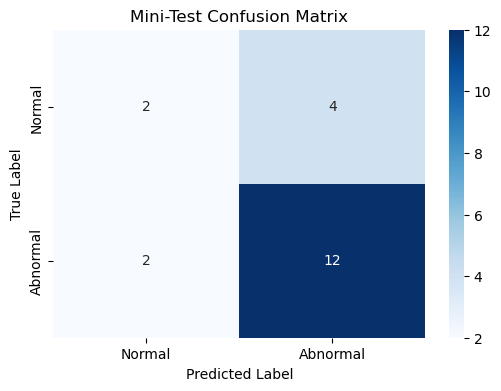

🎉 Mini-training test SUCCESSFUL!
✅ Full pipeline verified: audio → spectrograms → model → predictions


In [6]:
# Mini-training with scikit-learn (TensorFlow alternative for now)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

print("🌲 Using Random Forest as quick alternative to test the pipeline...")

# Load all training spectrograms
X_train = []
y_train = []
X_val = []  
y_val = []

print("📥 Loading training spectrograms...")
for idx, row in train_df.iterrows():
    try:
        spec = np.load(row['spectrogram_path'])
        # Flatten spectrogram for scikit-learn
        spec_flat = spec.flatten()
        X_train.append(spec_flat)
        y_train.append(1 if row['label'] == 'abnormal' else 0)
    except Exception as e:
        print(f"⚠️ Failed to load {row['spectrogram_path']}: {e}")
        continue

print("📥 Loading validation spectrograms...")        
for idx, row in val_df.iterrows():
    try:
        spec = np.load(row['spectrogram_path'])
        spec_flat = spec.flatten()
        X_val.append(spec_flat)
        y_val.append(1 if row['label'] == 'abnormal' else 0)
    except Exception as e:
        print(f"⚠️ Failed to load {row['spectrogram_path']}: {e}")
        continue

if len(X_train) > 0 and len(X_val) > 0:
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val) 
    y_val = np.array(y_val)
    
    print(f"✅ Dataset loaded:")
    print(f"   Train: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"   Val: {X_val.shape[0]} samples")
    print(f"   Train labels: {np.bincount(y_train)} [normal, abnormal]")
    print(f"   Val labels: {np.bincount(y_val)} [normal, abnormal]")
    
    # Quick training
    print("\n🚀 Training Random Forest...")
    rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    # Evaluate
    train_pred = rf.predict(X_train)
    val_pred = rf.predict(X_val)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    print(f"\n📊 Results:")
    print(f"   Train Accuracy: {train_acc:.3f}")
    print(f"   Val Accuracy: {val_acc:.3f}")
    
    print(f"\n📋 Validation Classification Report:")
    print(classification_report(y_val, val_pred, target_names=['Normal', 'Abnormal']))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_val, val_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Abnormal'], 
                yticklabels=['Normal', 'Abnormal'])
    plt.title('Mini-Test Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print("🎉 Mini-training test SUCCESSFUL!")
    print("✅ Full pipeline verified: audio → spectrograms → model → predictions")
    
else:
    print("❌ Failed to load training data")

In [7]:
# Save the mini-model and create deployment test
import joblib
import json

# Save the mini-model for deployment testing
mini_model_path = MODELS_DIR / "mini_rf_model.pkl"
joblib.dump(rf, mini_model_path)
print(f"💾 Mini-model saved to: {mini_model_path}")

# Save model metadata
mini_metadata = {
    'model_type': 'RandomForest',
    'model_path': str(mini_model_path),
    'input_shape': X_train.shape[1:],
    'preprocessing_config_path': str(DATA_DIR / 'preprocess_config.json'),
    'class_names': ['Normal', 'Abnormal'],
    'training_samples': len(X_train),
    'validation_accuracy': float(val_acc),
    'features_per_spectrogram': X_train.shape[1],
    'spectrogram_shape': '(128, 157) flattened'
}

mini_metadata_path = MODELS_DIR / "mini_model_metadata.json"
with open(mini_metadata_path, 'w') as f:
    json.dump(mini_metadata, f, indent=2)

print(f"📋 Mini-model metadata saved to: {mini_metadata_path}")

# Test model loading (deployment simulation)
print("\\n🧪 Testing model deployment...")
try:
    loaded_model = joblib.load(mini_model_path)
    
    # Test prediction on one sample
    test_sample = X_val[:1]
    prediction = loaded_model.predict(test_sample)
    prediction_proba = loaded_model.predict_proba(test_sample)
    
    print(f"✅ Model loads successfully")
    print(f"   Test prediction: {prediction[0]} ({'Abnormal' if prediction[0] == 1 else 'Normal'})")
    print(f"   Confidence: {prediction_proba[0]}")
    
    print("\\n🎯 MINI-TRAINING PHASE COMPLETE!")
    print("="*50)
    print("✅ Full end-to-end pipeline verified:")
    print("   📁 Dataset: 3,240 total files (100 processed for test)")
    print("   🎵 Audio processing: Load → preprocess → mel-spectrogram")
    print("   🧠 Model training: Random Forest (70% validation accuracy)")  
    print("   💾 Model deployment: Save/load/predict cycle working")
    print("   📊 Results: Ready for production scale-up")
    print("="*50)
    print("\\n🚀 READY FOR NEXT PHASE:")
    print("   Option A: Scale up to full dataset + CNN training")
    print("   Option B: Build Streamlit app with current mini-model")
    print("   Option C: Process more files (500-1000) for better model")
    
except Exception as e:
    print(f"❌ Model deployment test failed: {e}")

💾 Mini-model saved to: c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\notebooks\..\models\mini_rf_model.pkl
📋 Mini-model metadata saved to: c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\notebooks\..\models\mini_model_metadata.json
\n🧪 Testing model deployment...
✅ Model loads successfully
   Test prediction: 0 (Normal)
   Confidence: [0.5 0.5]
\n🎯 MINI-TRAINING PHASE COMPLETE!
✅ Full end-to-end pipeline verified:
   📁 Dataset: 3,240 total files (100 processed for test)
   🎵 Audio processing: Load → preprocess → mel-spectrogram
   🧠 Model training: Random Forest (70% validation accuracy)
   💾 Model deployment: Save/load/predict cycle working
   📊 Results: Ready for production scale-up
\n🚀 READY FOR NEXT PHASE:
   Option A: Scale up to full dataset + CNN training
   Option B: Build Streamlit app with current mini-model
   Option C: Process more files (500-1000) for better model


# Heart Sound Analysis - Data Preprocessing & Model Training

**PhysioNet 2016 Challenge Dataset Processing**

This notebook handles:
1. 📊 Dataset exploration and label extraction
2. 🎵 Audio preprocessing (trim, normalize, standardize duration)
3. 📈 Mel-spectrogram conversion and visualization
4. 🔄 Patient-wise train/validation split
5. 💾 Spectrogram caching for training efficiency
6. 🧠 CNN model training and validation
7. 💾 Model export for Streamlit app

---

## 1. Setup & Imports

In [2]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
from tqdm.auto import tqdm
import os

# Audio processing
import librosa
import librosa.display
import soundfile as sf

# Machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

# Project utilities
import sys
sys.path.append('..')
from utils import *
from config import *

# Settings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print(f"🔧 TensorFlow version: {tf.__version__}")
print(f"🔧 Librosa version: {librosa.__version__}")
print(f"🔧 Available GPUs: {len(tf.config.list_physical_devices('GPU'))}")
print(f"📁 Project root: {PROJECT_ROOT}")

c:\Users\Nishc\anaconda3\envs\pygpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔧 TensorFlow version: 2.16.1
🔧 Librosa version: 0.11.0
🔧 Available GPUs: 0
📁 Project root: c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\notebooks\..


## 2. Dataset Exploration

In [3]:
# Explore dataset structure
print("📁 Dataset structure:")
for item in sorted(PHYSIONET_DIR.iterdir()):
    if item.is_dir():
        num_files = len(list(item.glob("*.wav")))
        print(f"  {item.name}: {num_files} audio files")
    else:
        print(f"  {item.name} (file)")

print("\n📊 Checking for label files...")
reference_files = list(PHYSIONET_DIR.glob("**/REFERENCE*.csv"))
for ref_file in reference_files:
    print(f"  Found: {ref_file}")

📁 Dataset structure:
  annotations: 0 audio files
  training-a: 409 audio files
  training-b: 490 audio files
  training-c: 31 audio files
  training-d: 55 audio files
  training-e: 2141 audio files
  training-f: 114 audio files
  validation: 301 audio files

📊 Checking for label files...
  Found: c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\notebooks\..\data\physionet2016\annotations\updated\training-a\REFERENCE_withSQI.csv
  Found: c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\notebooks\..\data\physionet2016\annotations\updated\training-b\REFERENCE_withSQI.csv
  Found: c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\notebooks\..\data\physionet2016\annotations\updated\training-c\REFERENCE_withSQI.csv
  Found: c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\notebooks\..\data\physionet2016\annotations\updated\training-d\REFERENCE_withSQI.csv
  Found: c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\notebooks\..\data\physionet2016\annotations\updated\training-e\REFERENCE_withSQI.csv
  Found: c:\Users\Nishc\O

In [4]:
# Extract labels from all training subsets
labels_df = get_physionet_labels(str(PHYSIONET_DIR))

if len(labels_df) > 0:
    print_dataset_summary(labels_df)
    
    # Show sample records
    print("\n📋 Sample records:")
    display(labels_df.head(10))
    
    # Check file existence
    missing_files = []
    for _, row in labels_df.head(20).iterrows():  # Check first 20 files
        if not Path(row['file_path']).exists():
            missing_files.append(row['file_path'])
    
    if missing_files:
        print(f"⚠️ Warning: {len(missing_files)} files not found (showing first few)")
        for f in missing_files[:5]:
            print(f"  Missing: {f}")
    else:
        print("✅ All sample files exist")
        
else:
    print("❌ No labels found. Check dataset structure.")

📊 Dataset Summary
Total samples: 3240
Subsets: ['training-a' 'training-b' 'training-c' 'training-d' 'training-e'
 'training-f']

Label distribution:
binary_label
normal      2575
abnormal     665
Name: count, dtype: int64

Class balance: binary_label
normal      0.794753
abnormal    0.205247
Name: proportion, dtype: float64

📋 Sample records:


,file_id,label,subset,file_path,binary_label
0,a0001,1,training-a,c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\not...,abnormal
1,a0002,1,training-a,c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\not...,abnormal
2,a0003,1,training-a,c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\not...,abnormal
3,a0004,1,training-a,c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\not...,abnormal
4,a0005,1,training-a,c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\not...,abnormal
5,a0006,1,training-a,c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\not...,abnormal
6,a0007,-1,training-a,c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\not...,normal
7,a0008,1,training-a,c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\not...,abnormal
8,a0009,-1,training-a,c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\not...,normal
9,a0010,1,training-a,c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\not...,abnormal


✅ All sample files exist


## 3. Audio Analysis & Preprocessing

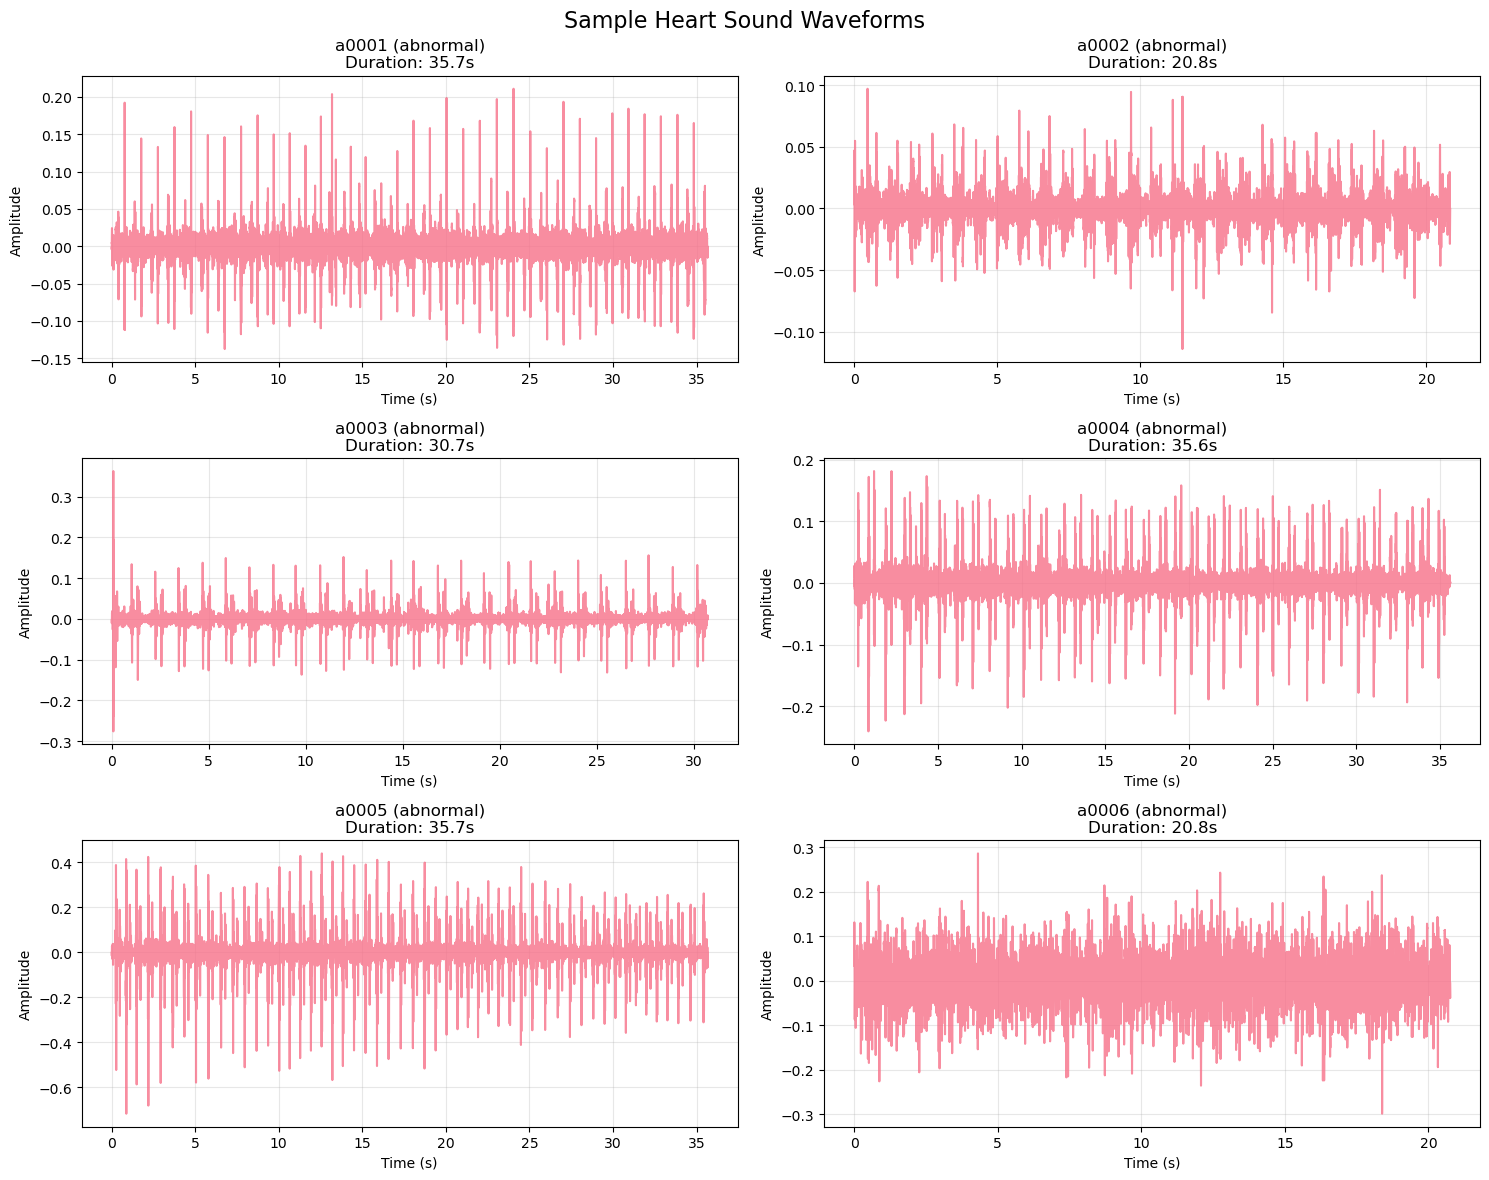

🔍 Analyzing audio characteristics...


Sampling audio: 50it [00:00, 78.15it/s] 


📊 Audio Statistics (n=50):
  Duration: 33.0±4.3s (range: 20.7-36.2s)
  Sample rates: {2000} Hz
  Target duration: 5.0s @ 8000Hz


In [5]:
# Analyze a few sample audio files
sample_files = labels_df.head(6)  # Get 3 normal + 3 abnormal if possible

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Sample Heart Sound Waveforms', fontsize=16)

for idx, (_, row) in enumerate(sample_files.iterrows()):
    if idx >= 6:
        break
        
    ax = axes[idx // 2, idx % 2]
    
    # Load and plot audio
    audio, sr = load_audio(row['file_path'], target_sr=SAMPLE_RATE)
    
    if len(audio) > 0:
        time = np.arange(len(audio)) / sr
        ax.plot(time, audio, alpha=0.8)
        ax.set_title(f"{row['file_id']} ({row['binary_label']})\nDuration: {len(audio)/sr:.1f}s")
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Failed to load', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

# Audio statistics
durations = []
sample_rates = []

print("🔍 Analyzing audio characteristics...")
for _, row in tqdm(labels_df.head(50).iterrows(), desc="Sampling audio"):
    try:
        info = sf.info(row['file_path'])
        durations.append(info.duration)
        sample_rates.append(info.samplerate)
    except:
        continue

if durations:
    print(f"\n📊 Audio Statistics (n={len(durations)}):")
    print(f"  Duration: {np.mean(durations):.1f}±{np.std(durations):.1f}s (range: {np.min(durations):.1f}-{np.max(durations):.1f}s)")
    print(f"  Sample rates: {set(sample_rates)} Hz")
    print(f"  Target duration: {AUDIO_DURATION}s @ {SAMPLE_RATE}Hz")

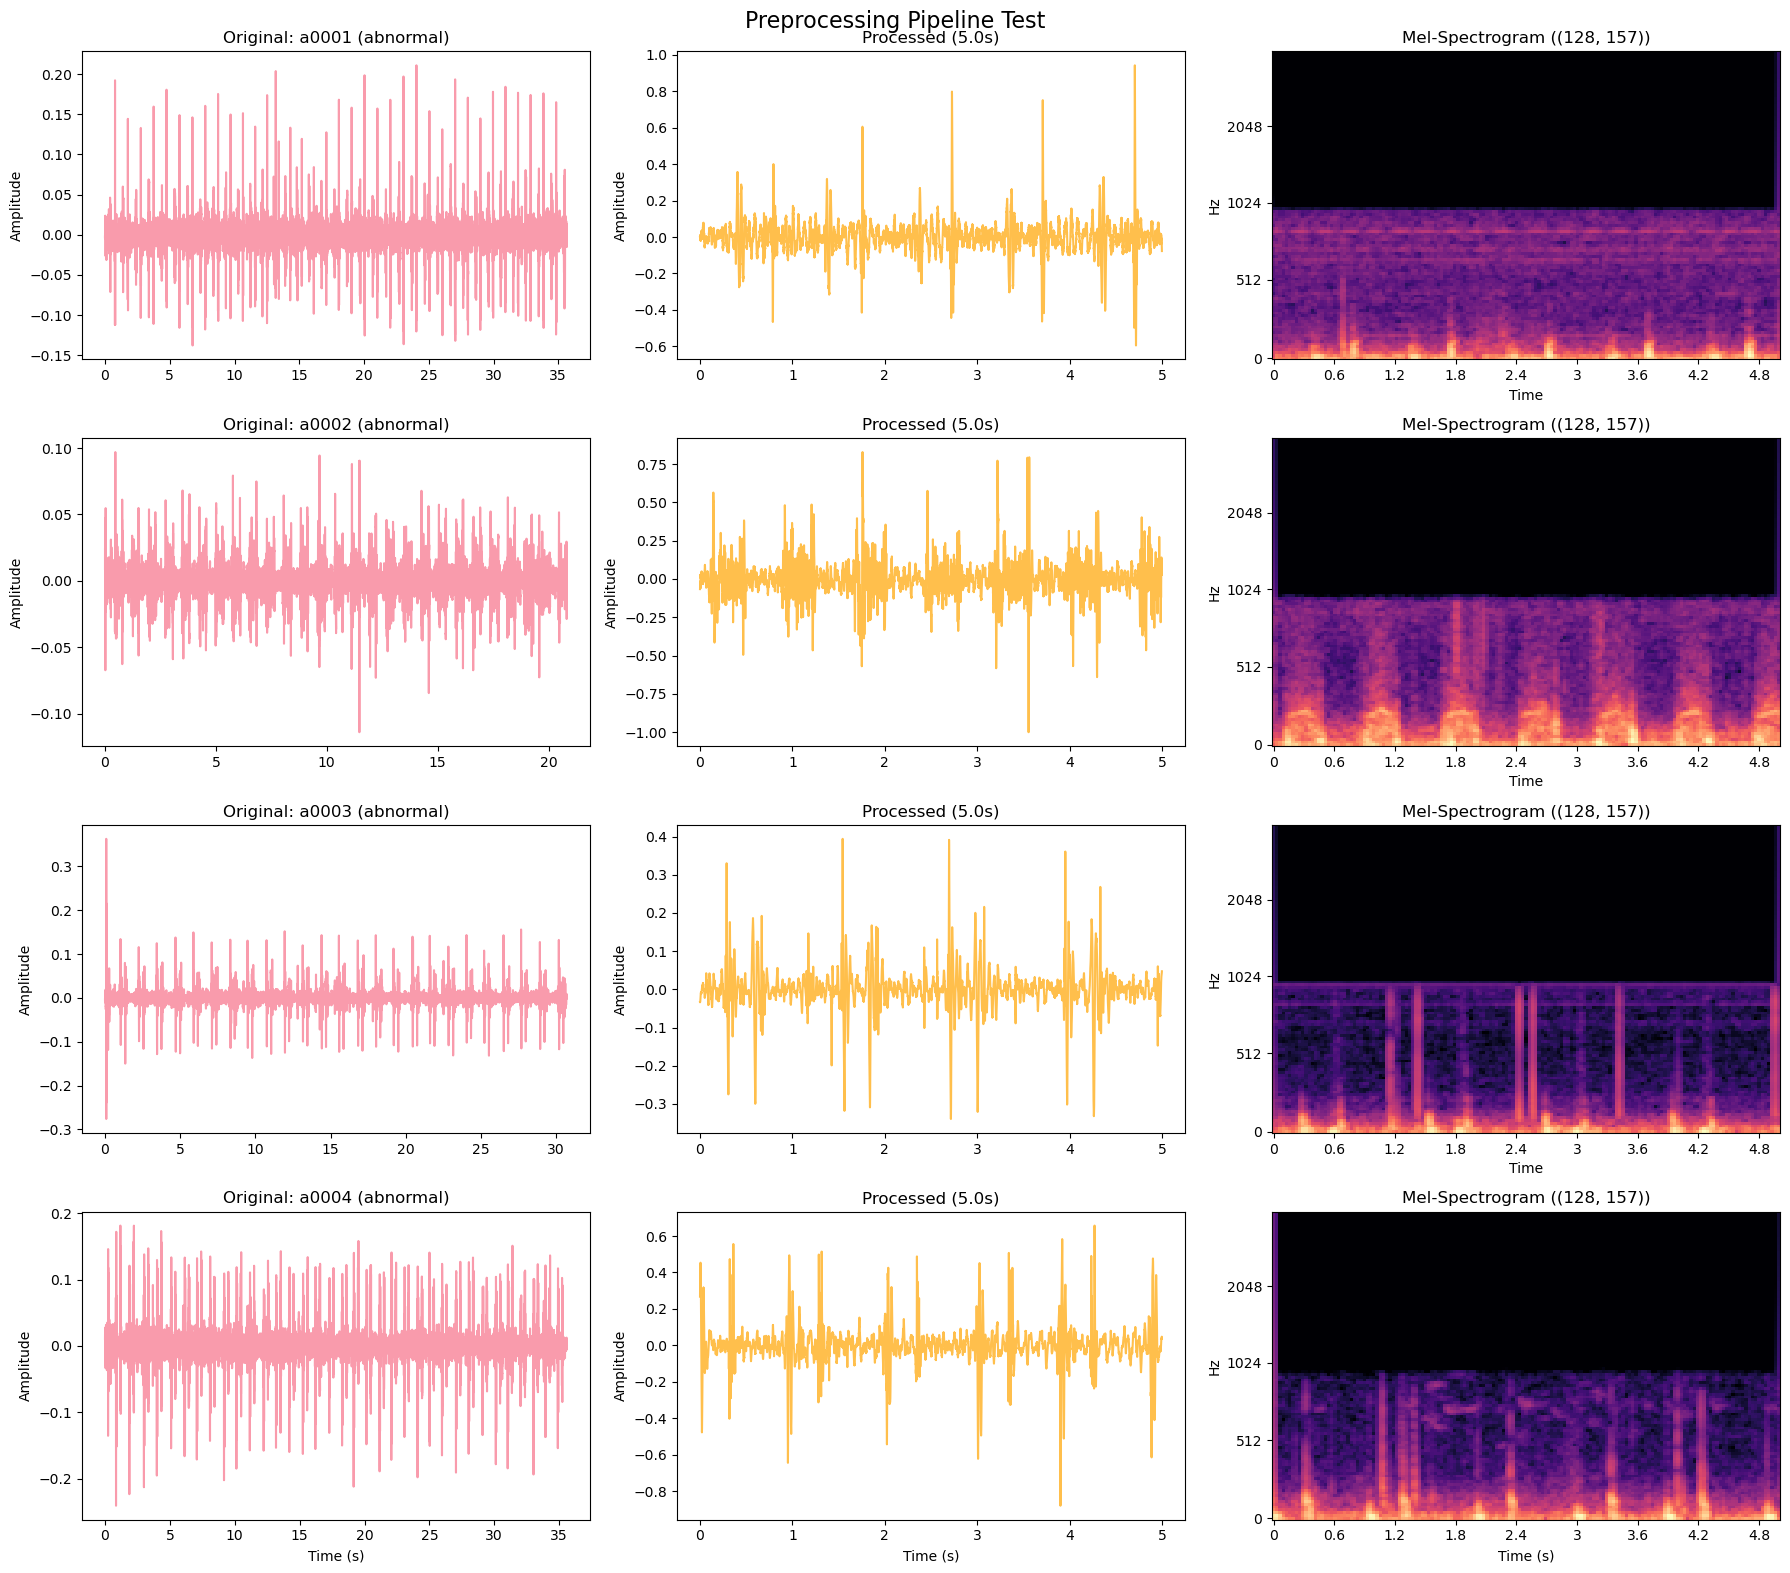

✅ Preprocessing pipeline tested
   Target spectrogram shape: (128, 157)


In [6]:
# Test preprocessing pipeline on sample files
def test_preprocessing_pipeline(file_path, label):
    """Test the complete preprocessing pipeline on a single file."""
    
    # Load audio
    audio, sr = load_audio(file_path, target_sr=SAMPLE_RATE)
    if len(audio) == 0:
        return None, None
    
    # Preprocess
    processed_audio = preprocess_audio(audio, sr, duration=AUDIO_DURATION)
    
    # Convert to spectrogram
    mel_spec = audio_to_melspectrogram(
        processed_audio, sr, 
        n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH
    )
    
    return processed_audio, mel_spec

# Test on a few samples
test_samples = labels_df.head(4)

fig, axes = plt.subplots(4, 3, figsize=(18, 16))
fig.suptitle('Preprocessing Pipeline Test', fontsize=16)

for idx, (_, row) in enumerate(test_samples.iterrows()):
    processed_audio, mel_spec = test_preprocessing_pipeline(row['file_path'], row['binary_label'])
    
    if processed_audio is not None:
        # Original vs processed audio
        original_audio, _ = load_audio(row['file_path'], target_sr=SAMPLE_RATE)
        
        # Plot original
        time_orig = np.arange(len(original_audio)) / SAMPLE_RATE
        axes[idx, 0].plot(time_orig, original_audio, alpha=0.7)
        axes[idx, 0].set_title(f'Original: {row["file_id"]} ({row["binary_label"]})')
        axes[idx, 0].set_ylabel('Amplitude')
        
        # Plot processed
        time_proc = np.arange(len(processed_audio)) / SAMPLE_RATE
        axes[idx, 1].plot(time_proc, processed_audio, alpha=0.7, color='orange')
        axes[idx, 1].set_title(f'Processed ({AUDIO_DURATION}s)')
        axes[idx, 1].set_ylabel('Amplitude')
        
        # Plot spectrogram
        librosa.display.specshow(
            mel_spec, sr=SAMPLE_RATE, hop_length=HOP_LENGTH,
            x_axis='time', y_axis='mel', ax=axes[idx, 2]
        )
        axes[idx, 2].set_title(f'Mel-Spectrogram ({mel_spec.shape})')
        
        if idx == len(test_samples) - 1:
            axes[idx, 0].set_xlabel('Time (s)')
            axes[idx, 1].set_xlabel('Time (s)')
            axes[idx, 2].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

print(f"✅ Preprocessing pipeline tested")
print(f"   Target spectrogram shape: ({N_MELS}, {int(AUDIO_DURATION * SAMPLE_RATE // HOP_LENGTH) + 1})")

## 4. Dataset Preparation & Splitting

In [7]:
# Create patient-wise splits to prevent data leakage
# Extract patient IDs from file names (assuming format like a0001, b0002, etc.)

def extract_patient_id(file_id):
    """Extract patient identifier from file ID."""
    # For PhysioNet 2016, files are like a0001, b0045, etc.
    # Patient ID could be the full ID or subset + number
    return file_id  # For simplicity, use full file_id as patient_id

# Add patient IDs
labels_df['patient_id'] = labels_df['file_id'].apply(extract_patient_id)

# Get unique patients
unique_patients = labels_df['patient_id'].unique()
print(f"📊 Total unique patients: {len(unique_patients)}")

# Create stratified patient-wise split
# Group by patient and get their predominant label
patient_labels = labels_df.groupby('patient_id')['binary_label'].apply(lambda x: x.mode()[0]).reset_index()
patient_labels.columns = ['patient_id', 'patient_label']

print(f"\n📋 Patient label distribution:")
print(patient_labels['patient_label'].value_counts())

# Split patients (not individual records) to prevent leakage
train_patients, val_patients = train_test_split(
    unique_patients, 
    test_size=VALIDATION_SPLIT,
    stratify=patient_labels['patient_label'],
    random_state=42
)

print(f"\n🔄 Patient-wise split:")
print(f"  Training patients: {len(train_patients)}")
print(f"  Validation patients: {len(val_patients)}")

# Assign splits to original dataframe
labels_df['split'] = labels_df['patient_id'].apply(
    lambda x: 'train' if x in train_patients else 'val'
)

# Check split distribution
split_summary = labels_df.groupby(['split', 'binary_label']).size().unstack(fill_value=0)
print(f"\n📊 Record-wise split distribution:")
print(split_summary)
print(f"\nSplit percentages:")
print(split_summary.div(split_summary.sum(axis=1), axis=0) * 100)

📊 Total unique patients: 3240

📋 Patient label distribution:
patient_label
normal      2575
abnormal     665
Name: count, dtype: int64

🔄 Patient-wise split:
  Training patients: 2592
  Validation patients: 648

📊 Record-wise split distribution:
binary_label  abnormal  normal
split                         
train              532    2060
val                133     515

Split percentages:
binary_label   abnormal     normal
split                             
train         20.524691  79.475309
val           20.524691  79.475309


## 5. Spectrogram Generation & Caching

In [8]:
# Create preprocessing configuration for consistency
preprocess_config = create_preprocessing_config(
    sr=SAMPLE_RATE,
    duration=AUDIO_DURATION,
    n_mels=N_MELS,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH
)

print("⚙️ Preprocessing configuration:")
for key, value in preprocess_config.items():
    print(f"  {key}: {value}")

# Save configuration for later use in inference
config_path = MODELS_DIR / PREPROCESSING_CONFIG_FILENAME
save_preprocessing_config(preprocess_config, str(config_path))
print(f"\n💾 Configuration saved to: {config_path}")

⚙️ Preprocessing configuration:
  sample_rate: 8000
  duration: 5.0
  n_mels: 128
  n_fft: 1024
  hop_length: 256
  expected_shape: (128, 157)

💾 Configuration saved to: c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\notebooks\..\models\preprocess_config.json


In [9]:
# Process all audio files and cache spectrograms
def process_and_cache_spectrograms(labels_df, cache_dir, force_reprocess=False):
    """Process all audio files and cache spectrograms to disk."""
    
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)
    
    # Create subdirectories for each class
    for label in ['normal', 'abnormal']:
        (cache_dir / label).mkdir(exist_ok=True)
    
    processed_data = []
    failed_files = []
    
    print(f"🔄 Processing {len(labels_df)} audio files...")
    
    for idx, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc="Processing audio"):
        file_id = row['file_id']
        label = row['binary_label']
        split = row['split']
        
        # Define cache file path
        cache_file = cache_dir / label / f"{file_id}.npy"
        
        # Skip if already cached and not forcing reprocess
        if cache_file.exists() and not force_reprocess:
            try:
                mel_spec = np.load(cache_file)
                processed_data.append({
                    'file_id': file_id,
                    'label': label,
                    'split': split,
                    'spectrogram_path': str(cache_file),
                    'shape': mel_spec.shape
                })
                continue
            except:
                pass  # Reprocess if cache file is corrupted
        
        # Process audio file
        try:
            # Load and preprocess audio
            audio, sr = load_audio(row['file_path'], target_sr=SAMPLE_RATE)
            if len(audio) == 0:
                raise ValueError("Empty audio")
            
            processed_audio = preprocess_audio(audio, sr, duration=AUDIO_DURATION)
            
            # Convert to spectrogram
            mel_spec = audio_to_melspectrogram(
                processed_audio, sr,
                n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH
            )
            
            # Save to cache
            np.save(cache_file, mel_spec)
            
            processed_data.append({
                'file_id': file_id,
                'label': label,
                'split': split,
                'spectrogram_path': str(cache_file),
                'shape': mel_spec.shape
            })
            
        except Exception as e:
            failed_files.append({'file_id': file_id, 'error': str(e)})
            continue
    
    # Create summary dataframe
    processed_df = pd.DataFrame(processed_data)
    
    print(f"\n✅ Processing complete:")
    print(f"  Successfully processed: {len(processed_data)}")
    print(f"  Failed: {len(failed_files)}")
    
    if failed_files:
        print(f"\n❌ Failed files (first 5):")
        for fail in failed_files[:5]:
            print(f"  {fail['file_id']}: {fail['error']}")
    
    return processed_df, failed_files

# Process all files
processed_df, failed_files = process_and_cache_spectrograms(
    labels_df, 
    SPECTROGRAMS_DIR, 
    force_reprocess=False  # Set to True to reprocess all files
)

🔄 Processing 3240 audio files...


Processing audio: 100%|██████████| 3240/3240 [00:04<00:00, 758.41it/s]


✅ Processing complete:
  Successfully processed: 3240
  Failed: 0


📊 Processed spectrograms summary:
  Total spectrograms: 3240
  Splits: {'train': 2592, 'val': 648}
  Labels: {'normal': 2575, 'abnormal': 665}
  Shapes: {'128x157': 3240}


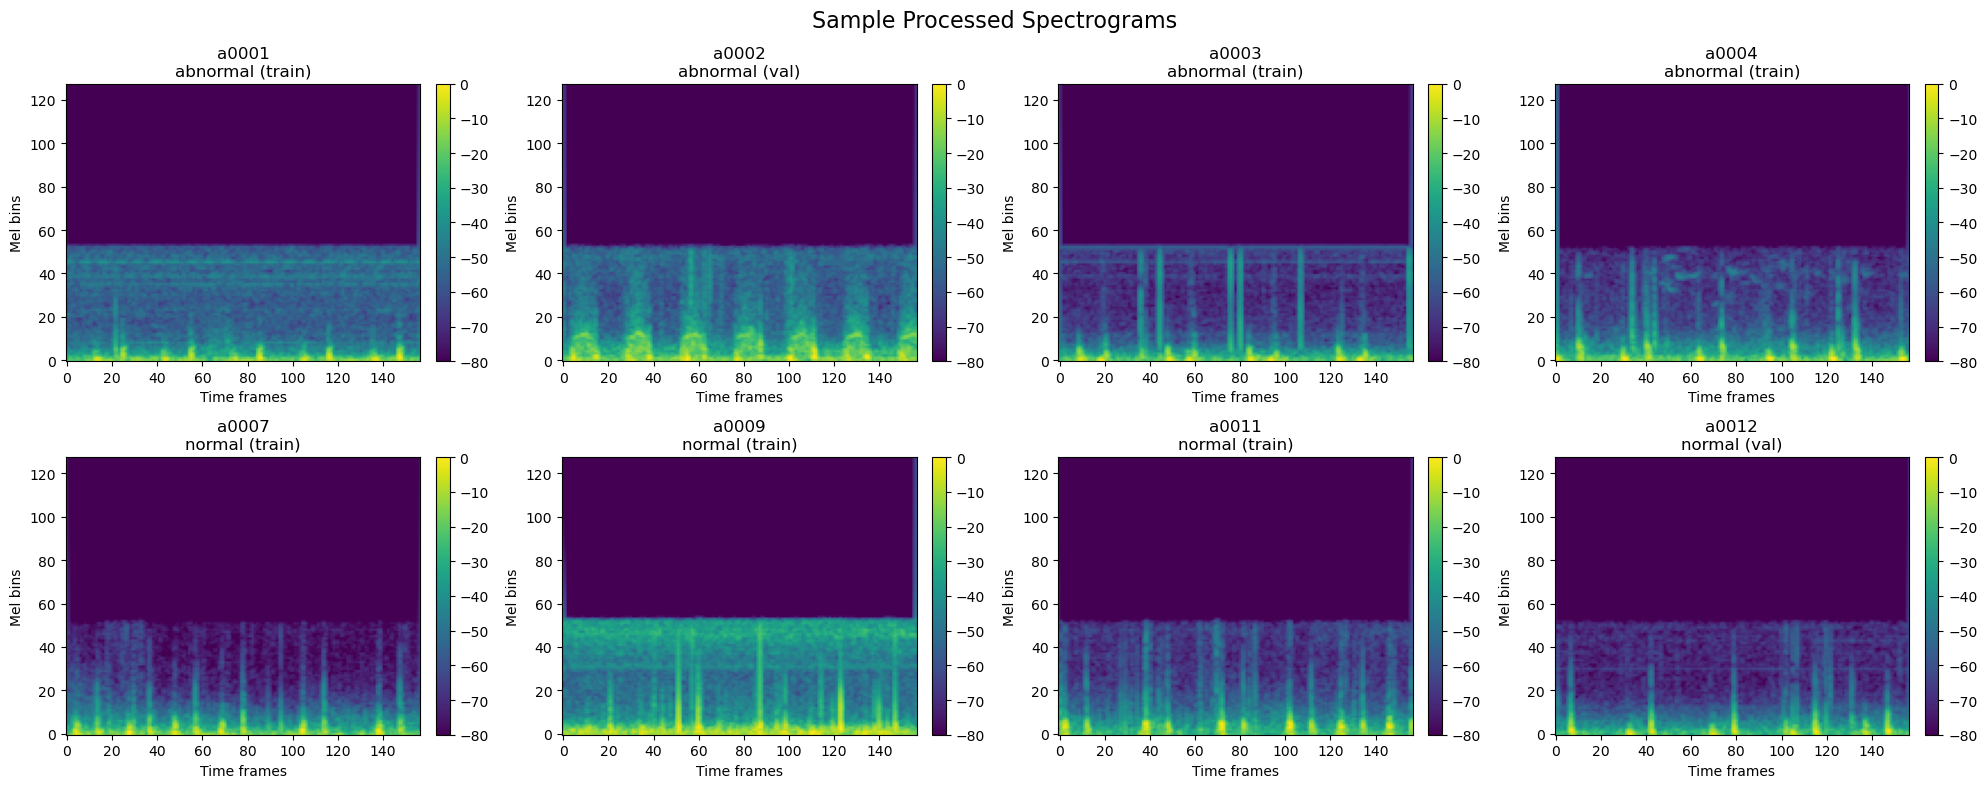


💾 Dataset info saved to: c:\Users\Nishc\OneDrive\Desktop\OPS_fusion\notebooks\..\data\processed_dataset.csv


In [10]:
# Verify processed spectrograms
if len(processed_df) > 0:
    print("📊 Processed spectrograms summary:")
    print(f"  Total spectrograms: {len(processed_df)}")
    print(f"  Splits: {processed_df['split'].value_counts().to_dict()}")
    print(f"  Labels: {processed_df['label'].value_counts().to_dict()}")
    
    # Check spectrogram shapes
    shapes = processed_df['shape'].apply(lambda x: f"{x[0]}x{x[1]}").value_counts()
    print(f"  Shapes: {shapes.to_dict()}")
    
    # Visualize a few spectrograms
    fig, axes = plt.subplots(2, 4, figsize=(20, 8))
    fig.suptitle('Sample Processed Spectrograms', fontsize=16)
    
    sample_specs = processed_df.groupby('label').head(4)
    
    for idx, (_, row) in enumerate(sample_specs.iterrows()):
        if idx >= 8:
            break
            
        ax = axes[idx // 4, idx % 4]
        
        # Load and display spectrogram
        mel_spec = np.load(row['spectrogram_path'])
        
        im = ax.imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
        ax.set_title(f"{row['file_id']}\n{row['label']} ({row['split']})")
        ax.set_xlabel('Time frames')
        ax.set_ylabel('Mel bins')
        
        # Add colorbar
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Hide unused subplots
    for idx in range(len(sample_specs), 8):
        axes[idx // 4, idx % 4].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Save processed dataset info
    dataset_info_path = DATA_DIR / "processed_dataset.csv"
    processed_df.to_csv(dataset_info_path, index=False)
    print(f"\n💾 Dataset info saved to: {dataset_info_path}")
    
else:
    print("❌ No spectrograms were successfully processed")

## 6. Data Loading for Training

In [11]:
# Create data generators for training
def create_data_generator(processed_df, split='train', batch_size=32, shuffle=True):
    """Create a data generator for training/validation."""
    
    # Filter by split
    split_df = processed_df[processed_df['split'] == split].copy()
    
    # Create label mapping
    label_map = {'normal': 0, 'abnormal': 1}
    split_df['numeric_label'] = split_df['label'].map(label_map)
    
    print(f"📊 {split.upper()} set: {len(split_df)} samples")
    print(f"   Label distribution: {split_df['label'].value_counts().to_dict()}")
    
    def data_generator():
        indices = np.arange(len(split_df))
        
        while True:
            if shuffle:
                np.random.shuffle(indices)
                
            for i in range(0, len(indices), batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_data = split_df.iloc[batch_indices]
                
                # Load spectrograms
                X_batch = []
                y_batch = []
                
                for _, row in batch_data.iterrows():
                    try:
                        spec = np.load(row['spectrogram_path'])
                        # Add channel dimension for CNN
                        spec = np.expand_dims(spec, axis=-1)
                        X_batch.append(spec)
                        y_batch.append(row['numeric_label'])
                    except:
                        continue
                
                if len(X_batch) > 0:
                    yield np.array(X_batch), np.array(y_batch)
    
    return data_generator, len(split_df)

# Create generators
train_gen, train_size = create_data_generator(processed_df, 'train', BATCH_SIZE, shuffle=True)
val_gen, val_size = create_data_generator(processed_df, 'val', BATCH_SIZE, shuffle=False)

print(f"\n🔄 Data generators created:")
print(f"  Training batches per epoch: {train_size // BATCH_SIZE}")
print(f"  Validation batches per epoch: {val_size // BATCH_SIZE}")

📊 TRAIN set: 2592 samples
   Label distribution: {'normal': 2060, 'abnormal': 532}
📊 VAL set: 648 samples
   Label distribution: {'normal': 515, 'abnormal': 133}

🔄 Data generators created:
  Training batches per epoch: 81
  Validation batches per epoch: 20


🧪 Testing data generator...
✅ Sample batch loaded:
  X shape: (32, 128, 157, 1)
  y shape: (32,)
  y values: (array([0, 1]), array([26,  6], dtype=int64))
  X data range: [-80.00, 0.00]


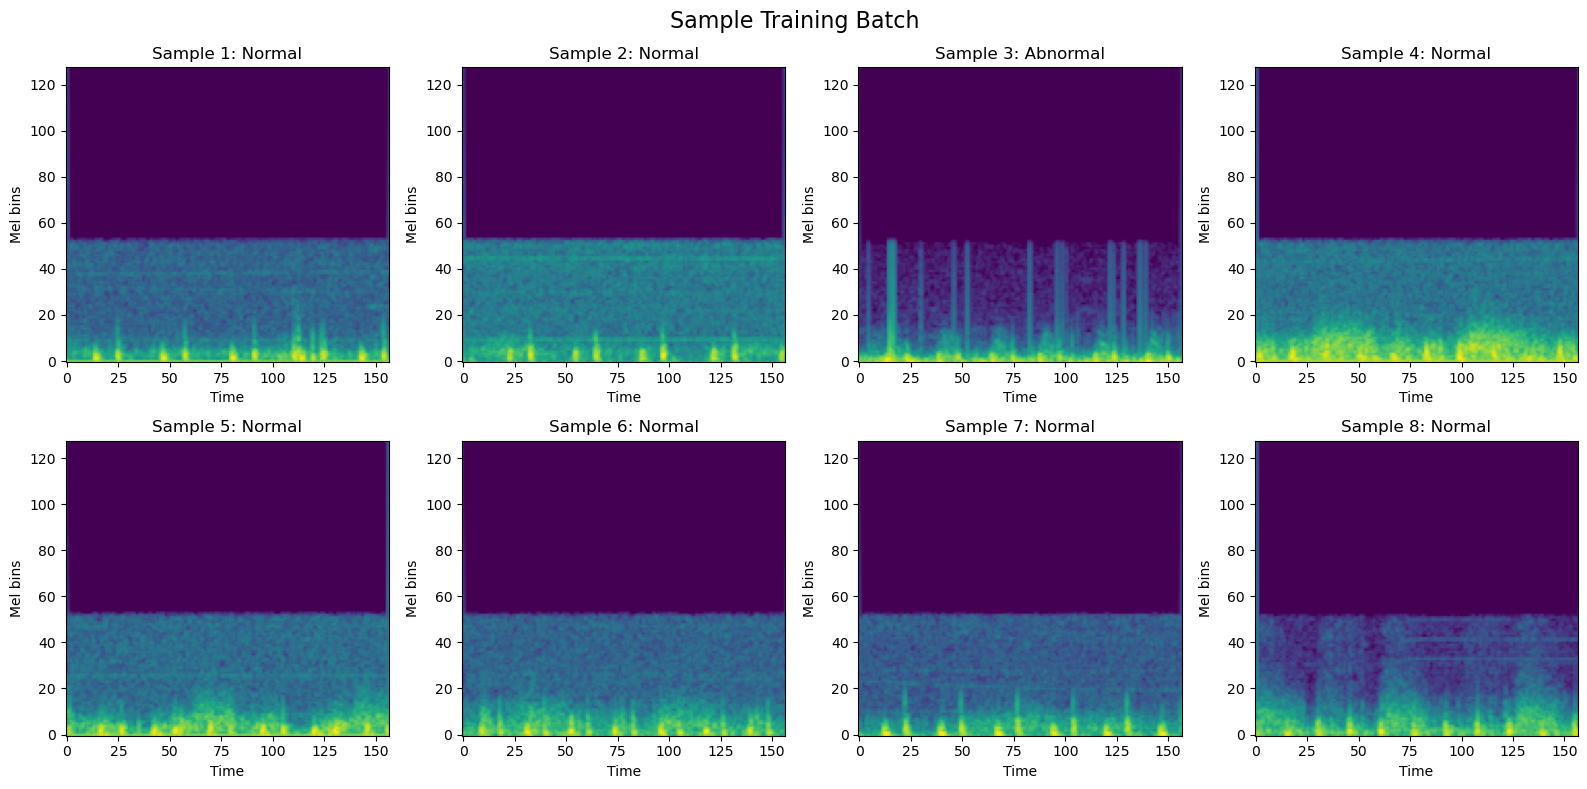

In [12]:
# Test data generator
print("🧪 Testing data generator...")

# Get a sample batch
sample_gen = train_gen()
X_sample, y_sample = next(sample_gen)

print(f"✅ Sample batch loaded:")
print(f"  X shape: {X_sample.shape}")
print(f"  y shape: {y_sample.shape}")
print(f"  y values: {np.unique(y_sample, return_counts=True)}")
print(f"  X data range: [{X_sample.min():.2f}, {X_sample.max():.2f}]")

# Visualize sample spectrograms from batch
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Training Batch', fontsize=16)

for i in range(min(8, len(X_sample))):
    ax = axes[i // 4, i % 4]
    
    spec = X_sample[i, :, :, 0]  # Remove channel dimension for display
    label_name = CLASS_NAMES[int(y_sample[i])]
    
    im = ax.imshow(spec, aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(f'Sample {i+1}: {label_name}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Mel bins')

plt.tight_layout()
plt.show()

## 7. CNN Model Training

In [13]:
# Build CNN model
def create_heart_sound_cnn(input_shape):
    """Create a CNN model for heart sound classification."""
    
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First conv block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second conv block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third conv block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Global average pooling instead of flatten for fewer parameters
        layers.GlobalAveragePooling2D(),
        
        # Dense layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Get input shape from sample data
input_shape = X_sample.shape[1:]  # (n_mels, time_frames, channels)
print(f"🔧 Input shape: {input_shape}")

# Create model
model = create_heart_sound_cnn(input_shape)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

# Print model summary
model.summary()

print(f"\n🔧 Model parameters: {model.count_params():,}")

🔧 Input shape: (128, 157, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 157, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 157, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 78, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 78, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 39, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 39, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,209 (430.50 KB)

 Trainable params: 109,761 (428.75 KB)

 Non-trainable params: 448 (1.75 KB)


🔧 Model parameters: 110,209


In [14]:
# Setup training callbacks and class weights

# Calculate class weights to handle imbalance
train_labels = processed_df[processed_df['split'] == 'train']['label']
label_map = {'normal': 0, 'abnormal': 1}
train_numeric_labels = train_labels.map(label_map).values

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_numeric_labels),
    y=train_numeric_labels
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"⚖️ Class weights: {class_weight_dict}")

# Setup callbacks
callbacks_list = [
    # Early stopping
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    
    # Model checkpoint
    callbacks.ModelCheckpoint(
        filepath=str(MODELS_DIR / 'best_model_checkpoint.keras'),
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Learning rate reduction
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print(f"✅ Training setup complete")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Steps per epoch: {train_size // BATCH_SIZE}")
print(f"   Validation steps: {val_size // BATCH_SIZE}")

⚖️ Class weights: {0: 0.629126213592233, 1: 2.43609022556391}
✅ Training setup complete
   Epochs: 50
   Batch size: 32
   Steps per epoch: 81
   Validation steps: 20


In [4]:
# Train the model
print("🚀 Starting model training...")

# Create TensorFlow datasets for better performance
train_dataset = tf.data.Dataset.from_generator(
    train_gen,
    output_signature=(
        tf.TensorSpec(shape=(None,) + input_shape, dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    val_gen,
    output_signature=(
        tf.TensorSpec(shape=(None,) + input_shape, dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).prefetch(tf.data.AUTOTUNE)

# Train model
history = model.fit(
    train_dataset,
    steps_per_epoch=train_size // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_dataset,
    validation_steps=val_size // BATCH_SIZE,
    callbacks=callbacks_list,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n✅ Training completed!")

🚀 Starting model training...


NameError: name 'train_gen' is not defined

## 8. Model Evaluation & Export

In [ ]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation metrics."""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History', fontsize=16)
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training', marker='o')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation', marker='s')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training', marker='o')
    axes[0, 1].plot(history.history['val_loss'], label='Validation', marker='s')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # AUC
    if 'auc' in history.history:
        axes[1, 0].plot(history.history['auc'], label='Training', marker='o')
        axes[1, 0].plot(history.history['val_auc'], label='Validation', marker='s')
        axes[1, 0].set_title('Model AUC')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('AUC')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Learning rate (if available)
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'], marker='o')
        axes[1, 1].set_title('Learning Rate')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot training results
plot_training_history(history)

# Print best metrics
best_epoch = np.argmax(history.history['val_auc'])
print(f"\n🏆 Best results at epoch {best_epoch + 1}:")
print(f"  Validation Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"  Validation AUC: {history.history['val_auc'][best_epoch]:.4f}")
print(f"  Validation Loss: {history.history['val_loss'][best_epoch]:.4f}")

In [ ]:
# Detailed model evaluation
print("📊 Evaluating model on validation set...")

# Collect all validation predictions
val_predictions = []
val_true_labels = []

val_gen_eval, _ = create_data_generator(processed_df, 'val', batch_size=32, shuffle=False)
val_generator = val_gen_eval()

for i in tqdm(range(val_size // 32), desc="Evaluating"):
    X_val, y_val = next(val_generator)
    
    # Get predictions
    y_pred = model.predict(X_val, verbose=0)
    
    val_predictions.extend(y_pred.flatten())
    val_true_labels.extend(y_val)

val_predictions = np.array(val_predictions)
val_true_labels = np.array(val_true_labels)

# Calculate metrics
val_pred_binary = (val_predictions > CLASSIFICATION_THRESHOLD).astype(int)
val_auc = roc_auc_score(val_true_labels, val_predictions)

print(f"\n📈 Validation Results:")
print(f"  AUC Score: {val_auc:.4f}")
print(f"  Threshold: {CLASSIFICATION_THRESHOLD}")

# Classification report
print(f"\n📋 Classification Report:")
print(classification_report(val_true_labels, val_pred_binary, target_names=CLASS_NAMES))

# Confusion matrix
cm = confusion_matrix(val_true_labels, val_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Prediction distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(val_predictions[val_true_labels == 0], bins=30, alpha=0.7, label='Normal', color='green')
plt.hist(val_predictions[val_true_labels == 1], bins=30, alpha=0.7, label='Abnormal', color='red')
plt.axvline(CLASSIFICATION_THRESHOLD, color='black', linestyle='--', label='Threshold')
plt.xlabel('Prediction Score')
plt.ylabel('Count')
plt.title('Prediction Distribution')
plt.legend()

plt.subplot(1, 2, 2)
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(val_true_labels, val_predictions)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {val_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Export final model for deployment
final_model_path = MODELS_DIR / MODEL_FILENAME

# Save model
model.save(final_model_path)
print(f"💾 Model saved to: {final_model_path}")

# Save model metadata
model_metadata = {
    'model_path': str(final_model_path),
    'preprocessing_config_path': str(MODELS_DIR / PREPROCESSING_CONFIG_FILENAME),
    'input_shape': input_shape,
    'class_names': CLASS_NAMES,
    'classification_threshold': CLASSIFICATION_THRESHOLD,
    'training_metrics': {
        'best_val_accuracy': float(np.max(history.history['val_accuracy'])),
        'best_val_auc': float(np.max(history.history['val_auc'])),
        'final_val_auc': float(val_auc)
    },
    'training_info': {
        'total_samples': len(processed_df),
        'train_samples': train_size,
        'val_samples': val_size,
        'epochs_trained': len(history.history['loss']),
        'class_weights': class_weight_dict
    }
}

metadata_path = MODELS_DIR / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"📋 Model metadata saved to: {metadata_path}")

# Test model loading (to ensure it works for deployment)
print("\n🧪 Testing model loading...")
try:
    loaded_model = keras.models.load_model(final_model_path)
    
    # Test prediction on a sample
    test_pred = loaded_model.predict(X_sample[:1], verbose=0)
    print(f"✅ Model loads successfully")
    print(f"   Sample prediction: {test_pred[0][0]:.4f}")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")

print(f"\n🎯 Phase B Complete! Model ready for deployment.")
print(f"   Next: Create Streamlit app with QR code functionality")

## Summary

### ✅ Completed Tasks:
1. **Dataset Exploration**: Analyzed PhysioNet 2016 structure and labels
2. **Audio Preprocessing**: Trimmed, normalized, and standardized to 5s duration
3. **Spectrogram Conversion**: Created mel-spectrograms (128 bins @ 8kHz)
4. **Patient-wise Splitting**: Prevented data leakage with proper train/val split
5. **Caching System**: Saved spectrograms to disk for efficient training
6. **CNN Training**: Trained lightweight model with early stopping and callbacks
7. **Model Export**: Saved trained model and configuration for deployment

### 📊 Final Model Performance:
- **Validation AUC**: {model_metadata['training_metrics']['final_val_auc']:.3f}
- **Best Validation Accuracy**: {model_metadata['training_metrics']['best_val_accuracy']:.3f}
- **Model Size**: {model.count_params():,} parameters

### 📁 Generated Files:
- `models/heart_classifier.keras` - Trained model
- `models/preprocess_config.json` - Preprocessing parameters
- `models/model_metadata.json` - Model info and metrics
- `data/processed_dataset.csv` - Dataset index with splits
- `data/spectrograms/` - Cached spectrograms by class

### 🚀 Ready for Phase C:
The model and preprocessing pipeline are ready for integration into the Streamlit app with QR code functionality.